<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v2/blob/main/myStocks_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyxirr

In [2]:
# import libraries

import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
import yfinance as yfin
import matplotlib.pyplot as plt

In [3]:
# notebook start time
import time
import datetime
import pytz

start_time = time.time()

# function to print date timestamp
def print_date_time():
  tz_NY = pytz.timezone('Asia/Kolkata')
  datetime_NY = datetime.datetime.now(tz_NY)
  print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

In [4]:
# function to get booked and reserved amount
def get_amt():
  py_booked_amt = 304000 + 1007000
  cy_booked_amt = 377000 + 297000 + 55000
  reserve_amt =  1000 + 30000
  total_booked_amt = py_booked_amt + cy_booked_amt
  return total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt

total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt = get_amt()

gen_output = 0

In [5]:
# function to format the amount
def format_amt(number):
    abs_number = abs(number)

    if abs_number >= 1_00_00_000:  # Crores
        formatted_amt = f"{number / 1_00_00_000:.2f} C"
    elif abs_number >= 1_00_000:  # Lakhs
        formatted_amt = f"{number / 1_00_000:.2f} L"
    elif abs_number >= 1_000:  # Thousands
        formatted_amt = f"{number / 1_000:.2f} K"
    else:
        formatted_amt = f"{number:.2f}"

    return formatted_amt

# function to set start and end date
def get_start_end_date():
  start_date = (datetime.date.today() + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
  end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
  return start_date, end_date

# function to fetch my portfolio csv
def get_mypfs_df():
  mypfs_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myPortfolioStocks.csv')
  return mypfs_df

# function to fetch my prospects csv
def get_mypps_df():
  mypps_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myProspectsScrips.csv')
  return mypps_df

# function to fetch screener data
def get_myscreen_df():
  myscreen_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myScreenerDB.csv')
  return myscreen_df

# function to fetch momentum data
def get_myinvmt_df():
  myinvmt_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myInvestments.csv')
  return myinvmt_df

# function to get the stock ids
def get_stock_ids(df_pf):
  stock_n100 = df_pf['Symbol'].unique()

  exclude = ['CADILAHC','MMTC', 'MASFIN']

  stock_ids = df_pf[~df_pf['Symbol'].isin(exclude) ]['Symbol'].unique()

  #mypf = mypf[mypf.Forecast.notnull()]
  #stock_ids = mypf['Symbol'].unique()

  stock_ids.sort()
  return stock_ids

# get features from screener data
def get_screener_features():
  myscreen_df = get_myscreen_df()
  cols = ['Symbol', 'EPS', 'MedPE', 'ROCE%', 'ROE%', 'CapType']
  return myscreen_df[cols]

# get relative strength
def get_relative_strength(stock_list):

    # Dictionary to store stock tickers and their corresponding percentage price change
    stock_changes = {}

    # Loop through each stock and fetch its price data
    for stock in stock_list:
        try:
            # Download the stock data for the given date range
            stock_data = yfin.Ticker(stock + '.NS').history(period='1mo', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]

            # Calculate the percentage change for the stock
            if len(stock_data) > 0:
                start_price = stock_data['Close'].iloc[0]
                end_price = stock_data['Close'].iloc[-1]
                percent_change = round(((end_price - start_price) / start_price) * 100, 2)
                stock_changes[stock] = percent_change
            else:
                stock_changes[stock] = np.nan  # If no data is available, set to NaN

        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")
            stock_changes[stock] = np.nan

    # Create a DataFrame with stock tickers and their percentage changes
    df = pd.DataFrame(list(stock_changes.items()), columns=['Symbol', 'Percent_Change'])

    # Drop any stocks with missing data (NaN values)
    df = df.dropna()

    # Calculate the percentile rank based on percentage change
    df['RSP'] = round(df['Percent_Change'].rank(pct=True) * 100, 2)
    cols = ['Symbol', 'RSP']
    df = df[cols]
    # Sort by percentile rank (optional)
    df = df.sort_values(by='RSP', ascending=False).reset_index(drop=True)

    return df


In [6]:
# function to get stock technicals
def stock_prec_dev(stock_symbol):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = yfin.Ticker(stock_symbol + '.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]

    stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Symbol'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)
    stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Prev_Close'] = stock_df['Close'].shift(1)
    stock_df.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
    stock_df = stock_df.tail(1)

    return stock_df

# function to compute stock attributes
def get_common_features(stock_ids, df_mypf):

  df_prec_dev = pd.DataFrame()
  df_tmp = get_screener_features()
  df_rs = get_relative_strength(stock_ids)

  for stock_id in stock_ids:
      tmp = stock_prec_dev(stock_id)
      tmp = tmp.reset_index()
      df_prec_dev = pd.concat([df_prec_dev, tmp], ignore_index = True)
  df_prec_dev = pd.merge(df_prec_dev, df_mypf, on= 'Symbol')
  df_prec_dev = pd.merge(df_prec_dev, df_tmp, on= 'Symbol', how='left')
  df_prec_dev = pd.merge(df_prec_dev, df_rs, on= 'Symbol', how='left')
  #print(df_prec_dev.columns)
  df_prec_dev['Curr_PE'] = round(df_prec_dev['Close']/df_prec_dev['EPS'],1)
  df_prec_dev['Dev%_PE'] = round((df_prec_dev['Curr_PE'] - df_prec_dev['MedPE'])*100/df_prec_dev['MedPE'],2)
  return df_prec_dev

# function to arrange stock features
def arrange_features(df_stocks, common_cols, diff_cols):
  df_stocks_common = df_stocks[common_cols].drop_duplicates()
  df_stocks_diff = df_stocks[diff_cols]
  df_stocks_diff['Investment'] = df_stocks_diff['AvgCost'] * df_stocks_diff['Shares']
  df_stocks_diff = df_stocks_diff.groupby(['Symbol'])[['Shares', 'Investment']].aggregate(['sum']).reset_index()
  df_stocks_diff.columns = ['Symbol', 'Shares', 'Investment']
  df_stocks_diff['AvgCost'] = round(df_stocks_diff['Investment']/df_stocks_diff['Shares'],2)
  df_stocks = pd.merge(df_stocks_diff, df_stocks_common, on='Symbol')
  return df_stocks

# plot fact distribution across dimension
def plot_pie_chart(df, dimension, fact):
  # grouping the data by category and calculating the sum of fact for each type
  grouped_data = df.groupby(dimension)[fact].sum()

  # sorting the grouped data in descending order
  grouped_data = grouped_data.sort_values(ascending=False)

  # creating a pie chart
  grouped_data.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

  # adding a title and displaying the plot
  plt.title(f'{dimension} {fact} Distribution')
  plt.ylabel('')  # To hide the y-label
  plt.show()

In [7]:
# function to get portfolio features

def get_portfolio_features(df_common_features):

  print_date_time()
  print('-------------------')

  #df_common_features["Target"] = df_common_features["Target"].fillna(df_common_features["Max"])
  df_common_features['NTT'] = np.where(df_common_features['Strategy']== 'NTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['LTT'] = np.where(df_common_features['Strategy']== 'BTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['BOL'] = df_common_features['Min']

  tmp_df = df_common_features[df_common_features['Symbol'].isin(mypf_df[mypf_df['InPortfolio'] != 'NA'].Symbol.values)]
  print('qualified stocks: '+str(len(tmp_df['Symbol'].unique())))
  tmp_df1 = tmp_df[tmp_df['LatestQtr'] == 1]
  print('with latest results: '+str(len(tmp_df1['Symbol'].unique())))
  tmp_df1 = tmp_df1[tmp_df1['StarStock'] == 1]
  print('still star stocks: '+str(len(tmp_df1['Symbol'].unique())))
  tmp_df['Investment'] = tmp_df['AvgCost'] * tmp_df['Shares']
  tmp_df['Current'] = round(tmp_df['Close'] * tmp_df['Shares'],0)
  tmp_df['Previous'] = tmp_df['Prev_Close'] * tmp_df['Shares']
  tmp_df['EstimatedST'] = tmp_df['NTT'] * tmp_df['Shares']
  tmp_df['EstimatedLT'] = tmp_df['LTT'] * tmp_df['Shares']
  tmp_df['Current P/L'] = round((tmp_df['Current'] - tmp_df['Investment']),0)
  tmp_df['Today P/L%'] = round((tmp_df['Current'] - tmp_df['Previous'])*100/tmp_df['Previous'],2)
  tmp_df['Current P/L%'] = round((tmp_df['Current'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedST P/L%'] = round((tmp_df['EstimatedST'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedLT P/L%'] = round((tmp_df['EstimatedLT'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['NTT%'] = round((tmp_df['NTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['LTT%'] = round((tmp_df['LTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['Gained%'] = round((tmp_df['Close'] - tmp_df['BOL'])*100/tmp_df['BOL'],2)
  investment = round(sum(tmp_df['AvgCost']*tmp_df['Shares']),0)
  current = round(sum(tmp_df['Close']*tmp_df['Shares']),0)
  tmp_df['InitAlloc%'] = round(tmp_df['Investment']*100/investment,2)
  tmp_df['CurrAlloc%'] = round(tmp_df['Current']*100/current,2)
  tmp_df['FTT'] = tmp_df['LTT']
  tmp_df.loc[tmp_df['Strategy'] == 'NTT', 'FTT'] = tmp_df['NTT']
  tmp_df['FTT%'] = tmp_df['LTT%']
  tmp_df.loc[tmp_df['Strategy'] == 'NTT', 'FTT%'] = tmp_df['NTT%']
  tmp_df['FTT Amt'] = round(tmp_df['FTT%'] * tmp_df['Current']/100,0)
  tmp_df['OTT%'] = round((tmp_df['FTT'] - tmp_df['AvgCost'])*100/tmp_df['AvgCost'],2)
  tmp_df['RRR Ind'] = round(tmp_df['Current P/L']/tmp_df['FTT Amt'],2)
  tmp_df['Risk Ind'] = round(tmp_df['Current P/L%']*tmp_df['CurrAlloc%'],0)

  return tmp_df

# function to print portfolio features
def print_portfolio_stats(df_portfolio_features, myinvmt_df):
  from pyxirr import xirr

  total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt = get_amt()

  dates = myinvmt_df['Date'].values
  dates = np.append(dates, datetime.date.today().strftime('%d-%b-%y'))
  investment = myinvmt_df['Investment'].values
  dates= pd.to_datetime(dates)

  current = round(sum(df_portfolio_features['Close']*df_portfolio_features['Shares']),0) + reserve_amt
  investment_xirr = np.append(investment, current)
  cagr = round(xirr(pd.DataFrame({"dates": dates, "amounts": investment_xirr}))*100,2)

  investment = -sum(investment)
  invested = round(sum(df_portfolio_features['AvgCost']*df_portfolio_features['Shares']),0) + reserve_amt
  previous = round(sum(df_portfolio_features['Prev_Close']*df_portfolio_features['Shares']),0) + reserve_amt
  cy_invested = investment + py_booked_amt

  today_pnl_amount = current-previous
  today_pnl_percentage = round((current-previous)*100/previous,2)

  curr_pnl_amount = current-invested
  curr_pnl_percentage = round((curr_pnl_amount)*100/(cy_invested),2)

  cy_pnl_amount = cy_booked_amt + curr_pnl_amount
  cy_pnl_percentage = round((cy_pnl_amount)*100/cy_invested,2)

  overall_pnl_amount = total_booked_amt + curr_pnl_amount
  overall_pnl_percentage = round((overall_pnl_amount)*100/investment,2)

  estimate_st = round(sum(df_portfolio_features['FTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_st_pnl_amount = estimate_st-current
  est_st_pnl_percentage = round((est_st_pnl_amount)*100/current,2)

  estimate_lt = round(sum(df_portfolio_features['LTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_lt_pnl_amount = estimate_lt-current
  est_lt_pnl_percentage = round((est_lt_pnl_amount)*100/current,2)

  total_profit = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Investment']),0)
  total_loss = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Investment']),0)

  cy_booked_percentage = round((cy_booked_amt)*100/current,2)
  py_booked_percentage = round((py_booked_amt)*100/investment,2)
  total_booked_percentage = round((total_booked_amt)*100/investment,2)

  print('-------------------')
  print('Initial Investment: ', format_amt(investment))
  print('CY Investment: ', format_amt(cy_invested))
  print('Reserve: ', format_amt(reserve_amt))
  print('Current: ',  format_amt(current))
  print('-------------------')
  print('Today PnL: '+ '{} ({}%)'.format(format_amt(today_pnl_amount), today_pnl_percentage))
  print('Current PnL: '+ '{} ({}%)'.format(format_amt(curr_pnl_amount), curr_pnl_percentage))
  print('CY Booked + Current PnL: '+ '{} ({}%)'.format(format_amt(cy_pnl_amount), cy_pnl_percentage))
  print('-------------------')
  print('Total profit: ', format_amt(total_profit))
  print('Total loss: ', format_amt(total_loss))
  print('-------------------')
  print('Total Booked + Current PnL: '+ '{} ({}%)'.format(format_amt(overall_pnl_amount), overall_pnl_percentage))
  print('Total Booked PnL: '+ '{} ({}%)'.format(format_amt(total_booked_amt), total_booked_percentage))
  print('Curr Year Booked PnL: '+ '{} ({}%)'.format(format_amt(cy_booked_amt), cy_booked_percentage))
  print('Prev Year Booked PnL: '+ '{} ({}%)'.format(format_amt(py_booked_amt), py_booked_percentage))
  print('===================')
  print('Est FTT: ',  format_amt(estimate_st))
  print('Est FTT PnL: '+ '{} ({}%)'.format(format_amt(est_st_pnl_amount), est_st_pnl_percentage))
  print('-------------------')
  print('Est LTT: ',  format_amt(estimate_lt))
  print('Est LTT PnL: '+ '{} ({}%)'.format(format_amt(est_lt_pnl_amount), est_lt_pnl_percentage))

  print('===================')
  print('Deployed: ', format_amt(investment))

  print('Current: ', format_amt(current))

  print('CAGR/XIRR %: '+'{}%'.format(cagr))

Run date time (IST): 2024-09-30 12:23:41
-------------------
qualified stocks: 86
with latest results: 82
still star stocks: 40
-------------------
Initial Investment:  95.12 L
CY Investment:  1.08 C
Reserve:  31.00 K
Current:  1.24 C
-------------------
Today PnL: 2.02 K (0.02%)
Current PnL: 8.21 L (7.59%)
CY Booked + Current PnL: 15.50 L (14.32%)
-------------------
Total profit:  12.73 L
Total loss:  -4.52 L
-------------------
Total Booked + Current PnL: 28.61 L (30.08%)
Total Booked PnL: 20.40 L (21.45%)
Curr Year Booked PnL: 7.29 L (5.88%)
Prev Year Booked PnL: 13.11 L (13.78%)
Est FTT:  1.83 C
Est FTT PnL: 59.07 L (47.62%)
-------------------
Est LTT:  2.30 C
Est LTT PnL: 1.06 C (85.72%)
Deployed:  95.12 L
Current:  1.24 C
CAGR/XIRR %: 28.81%


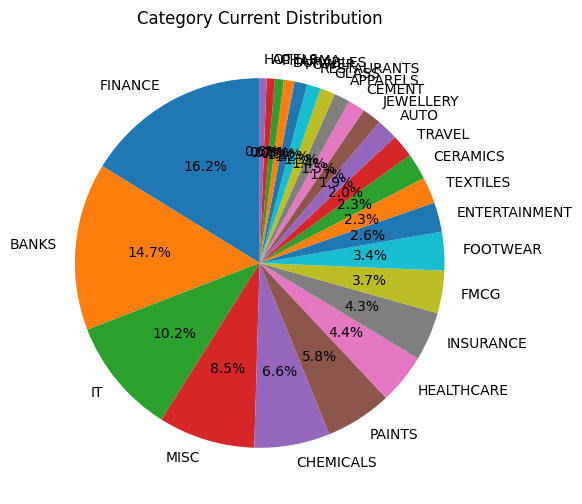

In [8]:
# get start and end date
start_date, end_date = get_start_end_date()

# get portfolio and prospects data
mypfs_df = get_mypfs_df()
mypps_df = get_mypps_df()
myinvmt_df = get_myinvmt_df()

# merge above datasets
mypf_df = pd.merge(mypfs_df, mypps_df, on="Symbol")

# seggregate dm and sv portfolio
dm_pf = mypf_df[mypf_df['InPortfolio'] == 'DM']
sv_pf = mypf_df[mypf_df['InPortfolio'] == 'SV']

# build portfolio stock dataframe
dm_stocks = get_stock_ids(dm_pf)
sv_stocks = get_stock_ids(sv_pf)
df_stocks = pd.concat([dm_pf,sv_pf], ignore_index = True)

# arrange common and diff stock features
common_cols = ['Symbol', 'Target', 'Criteria', 'Strategy', 'TFrame', 'LatestQtr', 'StarStock', 'BizFinTech', 'Conviction', 'Category', 'InFolio', 'XIRR', 'Remarks']
diff_cols = ['Symbol', 'AvgCost', 'Shares']
df_stocks = arrange_features(df_stocks, common_cols, diff_cols)

# get common features
stock_ids = df_stocks['Symbol'].values
df_common_features = get_common_features(stock_ids, df_stocks)

df_common_features.reset_index(drop=True, inplace=True)
df_common_features.drop(['Date'], axis=1, inplace=True)
# get and print portfolio features
df_portfolio_features = get_portfolio_features(df_common_features)

print_portfolio_stats(df_portfolio_features, myinvmt_df)

df = df_portfolio_features
plot_pie_chart(df, 'Category', 'Current')

In [9]:
# top 5 near their targets
cols = ['Symbol', 'AvgCost', 'Close', 'FTT', 'Dev%_PE', 'RSP', 'Current', 'Current P/L', 'FTT Amt', 'Today P/L%', 'Current P/L%', 'FTT%', 'OTT%', 'XIRR', 'RRR Ind', 'CurrAlloc%', 'Gained%', 'Criteria', 'Strategy', 'Category']
df_tmp = df_portfolio_features.sort_values(by = 'FTT Amt', ascending=True)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
57,PIDILITIND,2482.94,3379.25,3576.0,3.88,89.53,195996.0,51985.0,11407.0,0.47,36.10,5.82,44.02,27.0,4.56,1.58,47.96,X40,BTT,CHEMICALS
49,LALPATHLAB,2519.90,3301.00,3689.0,2.01,19.77,118836.0,28120.0,13963.0,0.89,31.00,11.75,46.39,51.0,2.01,0.96,64.79,X40N,NTT,HEALTHCARE
33,HCLTECH,1349.00,1813.05,2006.0,44.44,73.26,135979.0,34804.0,14468.0,0.26,34.40,10.64,48.70,128.0,2.41,1.10,53.92,X40,BTT,IT
43,JIOFIN,320.24,352.90,387.0,1.52,94.19,174333.0,16134.0,16841.0,-1.74,10.20,9.66,20.85,139.0,0.96,1.41,70.81,XSP,BTT,FINANCE
51,LTIM,5051.49,6218.15,7286.8,25.86,56.98,99490.0,18666.0,17102.0,1.34,23.09,17.19,44.25,22.0,1.09,0.80,36.57,X200,ATH,IT


In [10]:
# top 5 for average up
tmp_df = df_portfolio_features[(df_portfolio_features['Current P/L%'] > 15) & (df_portfolio_features['FTT%'] > 15) ].sort_values(by = 'RSP', ascending=False)
tmp_df[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
20,CAMPUS,294.86,340.35,631.85,30.86,97.67,193659.0,25884.0,165869.0,-3.13,15.43,85.65,114.29,187.0,0.16,1.57,58.67,XSP,ATH,FOOTWEAR
10,BAJAJFINSV,1473.47,1994.60,2392.00,-0.96,96.51,155579.0,40648.0,30991.0,-0.80,35.37,19.92,62.34,24.0,1.31,1.26,35.10,X40,BTT,FINANCE
71,SONACOMS,578.05,735.65,1006.00,1.51,87.21,128739.0,27580.0,47312.0,0.03,27.26,36.75,74.03,41.0,0.58,1.04,45.24,AR,BTT,AUTO
36,HINDUNILVR,2443.56,2953.00,3513.00,4.79,82.56,186039.0,32095.0,35273.0,-0.45,20.85,18.96,43.77,34.0,0.91,1.50,35.90,X40,BTT,FMCG
46,JUBLFOOD,487.35,676.95,874.00,6.39,76.74,151637.0,42471.0,44142.0,-1.64,38.90,29.11,79.34,34.0,0.96,1.23,57.39,AR,NTT,RESTAURANTS


In [11]:
# top 5 today
df_tmp = df_portfolio_features.sort_values(by = 'Today P/L%', ascending=False)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
44,JMFINANCIL,82.95,150.72,172.00,184.66,100.00,177397.0,79765.0,25048.0,5.48,81.70,14.12,107.35,96.0,3.18,1.43,114.98,XR,NTT,FINANCE
45,JPPOWER,18.73,18.23,26.20,-62.92,67.44,138056.0,-3786.0,60358.0,3.76,-2.67,43.72,39.88,133.0,-0.06,1.12,108.34,XSP,NTT,POWER
78,TRIDENT,37.35,36.69,62.00,96.24,37.21,90624.0,-1630.0,62512.0,2.86,-1.77,68.98,66.00,-5.0,-0.03,0.73,10.08,XR,NTT,TEXTILES
22,CLEAN,1389.74,1578.35,2018.00,5.60,80.23,129425.0,15466.0,36058.0,2.67,13.57,27.86,45.21,10.0,0.43,1.05,23.71,XR,NTT,CHEMICALS
5,ANGELONE,2246.65,2594.10,3791.17,-9.18,48.84,181587.0,24322.0,83802.0,2.44,15.47,46.15,68.75,106.0,0.29,1.47,42.32,X40N,ATH,FINANCE


In [12]:
# bottom 5 today
df_tmp = df_portfolio_features.sort_values(by = 'Today P/L%', ascending=True)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
20,CAMPUS,294.86,340.35,631.85,30.86,97.67,193659.0,25884.0,165869.0,-3.13,15.43,85.65,114.29,187.0,0.16,1.57,58.67,XSP,ATH,FOOTWEAR
64,SAMMAANCAP,170.35,162.50,326.00,NaN,65.12,97500.0,-4710.0,98104.0,-2.62,-4.61,100.62,91.37,NaN,-0.05,0.79,19.16,XR,NTT,FINANCE
84,VIPIND,488.80,541.40,718.00,NaN,95.35,105573.0,10257.0,34438.0,-2.49,10.76,32.62,46.89,NaN,0.30,0.85,25.30,X40N,NTT,MISC
7,ASIANTILES,75.41,86.89,137.00,-629.16,22.09,108091.0,14281.0,62336.0,-2.34,15.22,57.67,81.67,16.0,0.23,0.87,68.39,XR,NTT,CERAMICS
18,BOROLTD,348.25,401.50,462.00,NaN,18.60,161403.0,21406.0,24323.0,-2.13,15.29,15.07,32.66,90.0,0.88,1.30,33.70,XSP,NTT,GLASS


In [13]:
# top 5 RSP
df_tmp = df_portfolio_features.sort_values(by = 'RSP', ascending=False)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
44,JMFINANCIL,82.95,150.72,172.00,184.66,100.00,177397.0,79765.0,25048.0,5.48,81.70,14.12,107.35,96.0,3.18,1.43,114.98,XR,NTT,FINANCE
42,JCHAC,2143.67,2361.05,3542.00,NaN,98.84,87359.0,8043.0,43697.0,2.04,10.14,50.02,65.23,NaN,0.18,0.71,147.46,X40N,BTT,AC
20,CAMPUS,294.86,340.35,631.85,30.86,97.67,193659.0,25884.0,165869.0,-3.13,15.43,85.65,114.29,187.0,0.16,1.57,58.67,XSP,ATH,FOOTWEAR
10,BAJAJFINSV,1473.47,1994.60,2392.00,-0.96,96.51,155579.0,40648.0,30991.0,-0.80,35.37,19.92,62.34,24.0,1.31,1.26,35.10,X40,BTT,FINANCE
84,VIPIND,488.80,541.40,718.00,NaN,95.35,105573.0,10257.0,34438.0,-2.49,10.76,32.62,46.89,NaN,0.30,0.85,25.30,X40N,NTT,MISC


In [14]:
# top 5 of lower current allocation with minimal upside
df_tmp = df_portfolio_features[(df_portfolio_features['CurrAlloc%'] < 1) ].sort_values(by = 'FTT Amt', ascending=True)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
49,LALPATHLAB,2519.90,3301.00,3689.0,2.01,19.77,118836.0,28120.0,13963.0,0.89,31.00,11.75,46.39,51.0,2.01,0.96,64.79,X40N,NTT,HEALTHCARE
51,LTIM,5051.49,6218.15,7286.8,25.86,56.98,99490.0,18666.0,17102.0,1.34,23.09,17.19,44.25,22.0,1.09,0.80,36.57,X200,ATH,IT
24,DABUR,523.35,631.55,735.0,7.46,36.05,110521.0,18935.0,18103.0,-0.23,20.67,16.38,40.44,31.0,1.05,0.89,28.08,X40,BTT,FMCG
39,INDUSINDBK,1354.50,1444.10,1800.0,-18.46,61.63,82314.0,5108.0,20290.0,-1.27,6.62,24.65,32.89,8.0,0.25,0.67,7.92,XR,NTT,BANKS
16,BAYERCROP,4346.57,6356.85,8325.0,22.61,58.14,101710.0,32165.0,31489.0,0.88,46.25,30.96,91.53,33.0,1.02,0.82,34.13,X40N,BTT,CHEMICALS


In [15]:
# notebook execution time

end_time = time.time()
execution_time = round(end_time - start_time, 0)
print(f"Notebook execution time: {execution_time} seconds")

Notebook execution time: 21.0 seconds
